# LIBRARIES AND DATA

In [2]:
#Libraries: i'm not even sure which one i'm using
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math 
import pylab
from scipy import stats
from scipy import interpolate
from scipy.interpolate import Rbf
# from scipy.stats import kurtosis, skew
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from scipy.interpolate import *

In [21]:
#load data
# df = pd.read_excel('..\\data\\EquipmentAge.xlsx', index_col='EquipmentCode') ##### 93k records
# df = pd.read_excel('..\\data\\EquipmentAge_Partial.xlsx', index_col='EquipmentCode') ######1528 records with all 336 (a lot prefixes)
df = pd.read_excel('..\\data\\EquipmentAge_Partial_Partial.xlsx', index_col='EquipmentCode') #2 for testing
#Verify data size
df.shape
#Reason for splitting SN1 SN2:
#Cat assigns catserialnumberprefix to build configurations. For consistency purposes, each prefix is assigned to one manufacturing plant.
#We can predict age base on serial number since they are sequencial

(569, 13)

In [19]:
#Verify data types
df.dtypes

#YOYO MENTIONED TO CONVERT AGE TO INT IN MODELS AND TESTS. 
#I CANNOT DO IT NOW BECAUSE OF NULL BUT I WILL CONVERT DURING MODELLING BECAUSE I WILL DROP NULL. 
#HOPEFULLY BY THEN PANDAS KNOW ITS INT64

SerialNumber                    object
SN1                             object
SN2                              int64
ModelName                       object
CustomerAccountName             object
CustomerAccountCode              int64
CustomerAccount_Active           int64
CustomerAccount_Territory        int64
CustomerAccount_Internal         int64
Age_From_DBS                   float64
Age_From_Delivery              float64
Combined_Age_Pro_Built_Year    float64
Combined_Age_Pro_Delivery      float64
dtype: object

In [14]:
#Check for columns and print to copy later
df.columns

#MUTIPLE PREDICTIONS ARE NEEDED:
#PREDICTED BUILT YEAR: ONLY USE Age_From_DBS
#PREDICTED DELIVERY DATE: ONLY USE Age_From_Delivery
#PREDICTED_Age_Pro_Built_Year:
#PREDICTED_Age_Pro_Delivery:

#NOTE: I'm also keeping the customer columns so Bruce can decide which ones he will do parts estimation for

Index(['SerialNumber', 'SN1', 'SN2', 'ModelName', 'CustomerAccountName',
       'CustomerAccountCode', 'CustomerAccount_Active',
       'CustomerAccount_Territory', 'CustomerAccount_Internal', 'Age_From_DBS',
       'Age_From_Delivery', 'Combined_Age_Pro_Built_Year',
       'Combined_Age_Pro_Delivery'],
      dtype='object')

# TEST FOR BZY

In [22]:
# Testing with BZY
BZY = df.drop(df.index[df.SN1 != 'BZY'])
BZY.describe()

,SN2,CustomerAccountCode,CustomerAccount_Active,CustomerAccount_Territory,CustomerAccount_Internal,Age_From_DBS,Age_From_Delivery,Combined_Age_Pro_Built_Year,Combined_Age_Pro_Delivery
count,433.000000,433.00000,433.000000,433.000000,433.000000,189.000000,110.000000,189.000000,189.000000
mean,1950.307159,96474.39030,0.639723,0.930716,0.080831,76.698413,64.427273,76.698413,76.698413
std,945.576417,99319.21039,0.480636,0.254230,0.272891,30.406100,30.557649,30.406100,30.406100
min,138.000000,1102.00000,0.000000,0.000000,0.000000,24.000000,22.000000,24.000000,24.000000
25%,1037.000000,25957.00000,0.000000,1.000000,0.000000,48.000000,34.000000,48.000000,48.000000
50%,2446.000000,56026.00000,1.000000,1.000000,0.000000,96.000000,54.000000,96.000000,96.000000
75%,2734.000000,119061.00000,1.000000,1.000000,0.000000,96.000000,94.000000,96.000000,96.000000
max,7292.000000,547122.00000,1.000000,1.000000,1.000000,120.000000,107.000000,120.000000,120.000000


In [23]:
#Explore data
explore = BZY.drop(['SerialNumber'
    , 'ModelName'
    , 'CustomerAccountName'
    ,'SN1'
    ,'CustomerAccountCode'
    ,'CustomerAccount_Active'
    ,'CustomerAccount_Territory'
    , 'CustomerAccount_Internal'
#     ,'Age_From_Delivery'
    ,'Age_From_DBS'
    , 'Combined_Age_Pro_Built_Year'
    ,'Combined_Age_Pro_Delivery'
],axis=1)
# Correlation seems to confirm the theory, missing values are pretty high %
# import pandas_profiling as pp
# eda = pp.ProfileReport(BZY)
# display(eda)

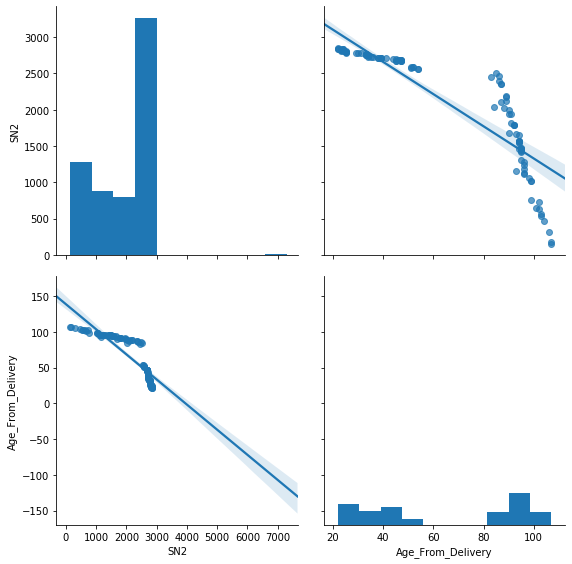

In [26]:
#From the scatter, i can tell this is not a linear relationship. After drawing a few more i decided to use interpolation \
#to compute predicted age.

sns.pairplot(explore, kind='reg', diag_kind='hist',
height=4, aspect=1,
plot_kws={'scatter_kws': {'alpha': 0.7}})

In [27]:
#DROP NA and convert to int for interp1d training
TRAIN = explore.dropna()

# D Convert to integer
X = TRAIN[['SN2']].squeeze()
X = X.astype(int)
Y = TRAIN[['Age_From_Delivery']].squeeze()
Y = Y.astype(int)

In [28]:
# M
model = interp1d(X, Y,kind='linear',fill_value="extrapolate")
#Note.  At the end i will test different interpolation "kind" by comparing linear regression errors.
#Note2: kind: str or int, optional
# Specifies the kind of interpolation as a string (‘linear’, ‘nearest’, ‘zero’, ‘slinear’, ‘quadratic’, ‘cubic’, ‘previous’, ‘next’, where ‘zero’, ‘slinear’, ‘quadratic’ and ‘cubic’ refer to a spline interpolation of zeroth, first, second or third order; ‘previous’ and ‘next’ simply return the previous or next value of the point) or as an integer specifying the order of the spline interpolator to use. Default is ‘linear’.

In [30]:
# T
t1 = model(456) #cat starts built at 100
t2 = model(200) #probably same as 105
t3 = model(500) #probably same as 105 or maybe +1
t4 = model(731) #heavy rents own this one. I think it was like 2013
t5 = model(1000) #I think this is the start of production peak from business exp
t6 = model(1500) 
t7 = model(1848) #heavy rents own this one. I think it was 2015
t8 = model(2000)
t9 = model(2575) #heavy rents own this one. I think it was like 2016
t10 = model(10000) #i don't think cat actually built this many..
t11 = model(20000) #i don't think cat actually built this many.
t12 = model(50000) #i don't think cat actually built this many.
print(t1)
print(t2)
print(t3)
print(t4)
print(t5)
print(t6)
print(t7)
print(t8)
print(t9)
print(t10)
print(t11)
print(t12)

104.06622516556291
106.8029197080292
103.51851851851852
101.31428571428572
99.0
94.66153846153846
91.0
89.71428571428571
51.0
22.0
22.0
22.0


In [31]:
#There is one serial number 7292. Looks suspicious. I will drop SN2 and Age (x and Y \
# \individually)by 3 standard deviation.
#I convereted Train to int but exlore still has them in float so i can calculate Z score and reduce sample
NEW_TRAIN = TRAIN[(np.abs(stats.zscore(TRAIN)) < 3).all(axis=1)]
NEW_TRAIN.describe()

,SN2,Age_From_Delivery
count,110.000000,110.000000
mean,2116.754545,64.427273
std,767.736112,30.557649
min,151.000000,22.000000
25%,1544.500000,34.000000
50%,2560.500000,54.000000
75%,2742.250000,94.000000
max,2844.000000,107.000000


In [33]:
# #DROP NA and convert to int for interp1d training
X = NEW_TRAIN[['SN2']].squeeze()
X = X.astype(int)
Y = NEW_TRAIN[['Age_From_Delivery']].squeeze()
Y = Y.astype(int)

In [34]:
# M
model = interp1d(X, Y,kind='linear',fill_value="extrapolate")

In [35]:
# T
t1 = model(105) #cat starts built at 100
t2 = model(200) #probably same as 105
t3 = model(500) #probably same as 105 or maybe +1
t4 = model(731) #heavy rents own this one. I think it was like 2013
t5 = model(1000) #I think this is the start of production peak from business exp
t6 = model(1500) 
t7 = model(1848) #heavy rents own this one. I think it was 2015
t8 = model(2000)
t9 = model(2575) #heavy rents own this one. I think it was like 2016
t10 = model(10000) #i don't think cat actually built this many..
t11 = model(20000) #i don't think cat actually built this many.
t12 = model(50000) #i don't think cat actually built this many.
print(t1)
print(t2)
print(t3)
print(t4)
print(t5)
print(t6)
print(t7)
print(t8)
print(t9)
print(t10)
print(t11)
print(t12)

#I thought i convereted them into integer? whatever

107.0
106.8029197080292
103.51851851851852
101.31428571428572
99.0
94.66153846153846
91.0
89.71428571428571
51.0
22.0
22.0
22.0


In [36]:
# THANK YOU SO MUCH YOYO!
for idx in BZY.index.values:
    BZY.loc[idx, 'Predicted_Age_By_DBS_Year'] = model(BZY.loc[idx, 'SN2'])

In [37]:
#Visual test passed. Next step is to loop different prefixes
BZY.to_csv('..\\data\\Output\\BZY_Interpolation_Age_Result_Pro_Delivery.csv')

# SHRINK DOWN FOR 1 PREFIX LOOP

In [172]:
# TEST = df.drop(df.index[df.SN1 != 'BZY'])
# OUTPUT = TEST
# EXPLORE1 = TEST.drop(['SerialNumber', 'ModelName', 'CustomerAccountName','SN1','CustomerAccountCode', 'CustomerAccount_Active','CustomerAccount_Territory', 'CustomerAccount_Internal',
#        'Age_From_Delivery', 'Combined_Age_Pro_Built_Year','Combined_Age_Pro_Delivery'],axis=1)
# EXPLORE2 = TEST.drop(['SerialNumber', 'ModelName', 'CustomerAccountName','SN1','CustomerAccountCode', 'CustomerAccount_Active','CustomerAccount_Territory', 'CustomerAccount_Internal',
#        'Age_From_DBS', 'Combined_Age_Pro_Built_Year','Combined_Age_Pro_Delivery'],axis=1)
# EXPLORE3 = TEST.drop(['SerialNumber', 'ModelName', 'CustomerAccountName','SN1','CustomerAccountCode', 'CustomerAccount_Active','CustomerAccount_Territory', 'CustomerAccount_Internal',
#        'Age_From_Delivery','Age_From_Delivery','Combined_Age_Pro_Built_Year'],axis=1)
# TRAIN1 = EXPLORE1.dropna()
# TRAIN2 = EXPLORE2.dropna()
# TRAIN3 = EXPLORE3.dropna()
# NEW_TRAIN1 = TRAIN1[(np.abs(stats.zscore(TRAIN1)) < 3).all(axis=1)]
# NEW_TRAIN2 = TRAIN2[(np.abs(stats.zscore(TRAIN2)) < 3).all(axis=1)]
# NEW_TRAIN3 = TRAIN3[(np.abs(stats.zscore(TRAIN3)) < 3).all(axis=1)]
# X1 = NEW_TRAIN1[['SN2']].squeeze()
# X1 = X1.astype(int)
# X2 = NEW_TRAIN2[['SN2']].squeeze()
# X2 = X2.astype(int)
# X3 = NEW_TRAIN3[['SN2']].squeeze()
# X3 = X3.astype(int)
# Y1 = NEW_TRAIN1[['Age_From_DBS']].squeeze() / 12
# Y1 = Y1.astype(int)
# Y2 = NEW_TRAIN2[['Age_From_Delivery']].squeeze()
# Y2 = Y2.astype(int)
# Y3 = NEW_TRAIN3[['Combined_Age_Pro_Delivery']].squeeze()
# Y3 = Y3.astype(int)
# model1 = interp1d(X1, Y1,kind='linear',fill_value="extrapolate") ###Note: In order to calculate more sensible DBS year, train with Year
# model2 = interp1d(X2, Y2,kind='linear',fill_value="extrapolate")
# model3 = interp1d(X3, Y3,kind='linear',fill_value="extrapolate")
# for idx in OUTPUT.index.values:
#     OUTPUT.loc[idx, 'Predicted_Age_By_DBS_Year'] = model1(OUTPUT.loc[idx, 'SN2'])
#     OUTPUT.loc[idx, 'Predicted_Age_By_Delivery'] = model2(OUTPUT.loc[idx, 'SN2'])
#     OUTPUT.loc[idx, 'Predicted_Age_Pro_Delivery'] = model3(OUTPUT.loc[idx, 'SN2'])
# OUTPUT.to_csv('..\\data\\Output\\BZY.csv')

TypeError: unsupported operand type(s) for /: 'str' and 'int'

# ADD LOOP FOR MULTIPLE PREFIX

In [3]:
df = pd.read_excel('..\\data\\EquipmentAge_Partial_Partial.xlsx', index_col='EquipmentCode')
#Create list for loop. I only need to build prefix number of models
prefix = list(dict.fromkeys(list(df['SN1'])))
print('Tasks list:',prefix)

#Clone df for output df
output = df
output['Predicted_Age_By_DBS_Year'] = 'NULL'
output['Predicted_Age_By_Delivery'] = 'NULL'
output['Predicted_Age_Combined_Pro_Delivery'] = 'NULL'

print(output.describe())

for x in prefix:   #while loopingthrough prefix, delete all other prefix
    print('Starting prefix:',x)
    TEST = output.drop(output.index[output.SN1 != x])

    OUTPUT = TEST.drop(['SerialNumber', 'ModelName', 'CustomerAccountName','SN1','CustomerAccountCode', 'CustomerAccount_Active','CustomerAccount_Territory', 'CustomerAccount_Internal',
           'Combined_Age_Pro_Built_Year'],axis=1) 
    OUTPUT['Predicted_Age_By_DBS_Year'] = ''
    OUTPUT['Predicted_Age_By_Delivery'] = ''
    OUTPUT['Predicted_Age_Combined_Pro_Delivery'] = ''
    EXPLORE1 = TEST.drop(['SerialNumber', 'ModelName', 'CustomerAccountName','SN1','CustomerAccountCode', 'CustomerAccount_Active','CustomerAccount_Territory', 'CustomerAccount_Internal',
           'Age_From_Delivery', 'Combined_Age_Pro_Built_Year','Combined_Age_Pro_Delivery','Predicted_Age_By_DBS_Year','Predicted_Age_By_Delivery','Predicted_Age_Combined_Pro_Delivery'],axis=1) 
    EXPLORE2 = TEST.drop(['SerialNumber', 'ModelName', 'CustomerAccountName','SN1','CustomerAccountCode', 'CustomerAccount_Active','CustomerAccount_Territory', 'CustomerAccount_Internal',
           'Age_From_DBS', 'Combined_Age_Pro_Built_Year','Combined_Age_Pro_Delivery','Predicted_Age_By_DBS_Year','Predicted_Age_By_Delivery','Predicted_Age_Combined_Pro_Delivery'],axis=1)
    EXPLORE3 = TEST.drop(['SerialNumber', 'ModelName', 'CustomerAccountName','SN1','CustomerAccountCode', 'CustomerAccount_Active','CustomerAccount_Territory', 'CustomerAccount_Internal',
           'Age_From_DBS','Age_From_Delivery','Age_From_Delivery','Combined_Age_Pro_Built_Year','Predicted_Age_By_DBS_Year','Predicted_Age_By_Delivery','Predicted_Age_Combined_Pro_Delivery'],axis=1)
    
    TRAIN1 = EXPLORE1.dropna()
    TRAIN2 = EXPLORE2.dropna()
    TRAIN3 = EXPLORE3.dropna()
    
    print(OUTPUT.size)
    print('Filter data by 3 standard deviation')
    
    NEW_TRAIN1 = TRAIN1[(np.abs(stats.zscore(TRAIN1)) < 3).all(axis=1)]
    nt1 = NEW_TRAIN1.size
    print('NT1 size:',nt1)
    print(NEW_TRAIN1.columns)
    
    NEW_TRAIN2 = TRAIN2[(np.abs(stats.zscore(TRAIN2)) < 3).all(axis=1)]
    nt2 = NEW_TRAIN2.size
    print('NT2 size:',nt2)
    print(NEW_TRAIN2.columns)
    
    NEW_TRAIN3 = TRAIN3[(np.abs(stats.zscore(TRAIN3)) < 3).all(axis=1)]
    nt3 = NEW_TRAIN3.size
    print('NT3 size:',nt3)
    print(NEW_TRAIN3.columns)
    print('Data Loaded')    

    X1 = TRAIN1[['SN2']].squeeze()
    X1 = X1.astype(int)    
    Y1 = TRAIN1[['Age_From_DBS']].squeeze() / 12
    Y1 = Y1.astype(int)

    X2 = NEW_TRAIN2[['SN2']].squeeze()
    X2 = X2.astype(int)
    Y2 = NEW_TRAIN2[['Age_From_Delivery']].squeeze()
    Y2 = Y2.astype(int)

    X3 = NEW_TRAIN3[['SN2']].squeeze()
    X3 = X3.astype(int)
    Y3 = NEW_TRAIN3[['Combined_Age_Pro_Delivery']].squeeze()
    Y3 = Y3.astype(int)

    print('Start Training')

    if NEW_TRAIN1.size > 0:
        model1 = interp1d(X1, Y1,kind='linear',fill_value="extrapolate")
    if NEW_TRAIN2.size > 0:
        model2 = interp1d(X2, Y2,kind='linear',fill_value="extrapolate")
    if NEW_TRAIN3.size > 0:  
        model3 = interp1d(X3, Y3,kind='linear',fill_value="extrapolate")

    print('Training complete')
#     print('Results_df')
#     print(OUTPUT.describe())
    print('Start Estimation')
    for idx in OUTPUT.index.values:
        if NEW_TRAIN1.size > 0:
            OUTPUT.loc[idx, 'Predicted_Age_By_DBS_Year'] = model1(OUTPUT.loc[idx, 'SN2'])
        if NEW_TRAIN2.size > 0:
            OUTPUT.loc[idx, 'Predicted_Age_By_Delivery'] = model2(OUTPUT.loc[idx, 'SN2'])
        if NEW_TRAIN3.size > 0:
            OUTPUT.loc[idx, 'Predicted_Age_Combined_Pro_Delivery'] = model3(OUTPUT.loc[idx, 'SN2'])
#     print('Results_df_after')        
#     print(OUTPUT.describe())
#     print('Prefix estimation complete, starting to merge data')
    

#     pd.concat([OUTPUT,output],axis=1,sort=False)
    
    print('Data loaded to output, move on to next prefix')
    print(output)
print('All estimation completed. Ready to export')
output.to_csv('..\\data\\Output\\Age_Predict.csv')
print('export completed')
# print(output.describe())

Tasks list: ['RKB', 'BZY']
                SN2  CustomerAccountCode  CustomerAccount_Active  \
count    569.000000           569.000000              569.000000   
mean    3262.493849         98527.889279                0.664323   
std     4761.808640        105297.454399                0.472642   
min      138.000000          1102.000000                0.000000   
25%     1069.000000         25957.000000                0.000000   
50%     2248.000000         56019.000000                1.000000   
75%     2759.000000        186426.000000                1.000000   
max    21404.000000        547123.000000                1.000000   

       CustomerAccount_Territory  CustomerAccount_Internal  Age_From_DBS  \
count                 569.000000                569.000000    245.000000   
mean                    0.922671                  0.094903     69.795918   
std                     0.267347                  0.293339     30.697479   
min                     0.000000                  0.0000

Data loaded to output, move on to next prefix
                     SerialNumber  SN1    SN2 ModelName  \
EquipmentCode                                             
103916                   RKB00301  RKB    301     336FL   
103917                   RKB00305  RKB    305     336FL   
103918                   RKB00314  RKB    314     336FL   
103919                   RKB00316  RKB    316     336FL   
103920                   RKB00326  RKB    326     336FL   
...                           ...  ...    ...       ...   
866677                   RKB21050  RKB  21050     336FL   
866678                   RKB21236  RKB  21236     336FL   
872486         BZY00168            BZY    168     336EL   
872727                   RKB10293  RKB  10293     336FL   
872733                   RKB10402  RKB  10402     336FL   

                                             CustomerAccountName  \
EquipmentCode                                                      
103916               TERANORTH CONSTRUCTION& ENGIN

# TEST RESULTS

In [ ]:
#load data
data2 = pd.read_csv('..\\data\\Output\\Interpolation_Age_Results.csv', index_col='EquipmentCode')
#Verify data types
data2.columns

In [ ]:
test = data2.drop(['SerialNumber','SN1','SN2','ModelName'],axis=1)
test.shape

In [ ]:
test1 = data2.drop(['Combined_Age_Pro_Built_Year','Predicted_Age_Pro_Built_Year'],axis=1)
test1 = test1.dropna()
X = test1[['Predicted_Age_Pro_Delivery']].squeeze()
Y = test1[['Combined_Age_Pro_Delivery']].squeeze()
# create a OLS model.
model = sm.OLS(Y, X)

#Print
results = model.fit()
print(results.summary())

In [ ]:
test2 = data2.drop(['Combined_Age_Pro_Delivery','Predicted_Age_Pro_Delivery'],axis=1)
test2 = test2.dropna()
X = test2[['Predicted_Age_Pro_Built_Year']].squeeze()
Y = test2[['Combined_Age_Pro_Built_Year']].squeeze()
# create a OLS model.
model = sm.OLS(Y, X)

#Print
results = model.fit()
print(results.summary())

In [ ]:
sns.pairplot(test, kind='reg', diag_kind='hist',
             height=3, aspect=1,
             plot_kws={'scatter_kws': {'alpha': 0.7}})